In [14]:
import os
import subprocess
import numpy as np
import os
import subprocess
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

from src.utils.synthetic_seqdata import *
from src.utils.datasets import DNASequenceDataset
from src.models.deepbind_cnn import BasicCNN

In [6]:
import sys
sys.path.insert(0, '..')


In [19]:
# download and load the data
savedir = "./data"
# download_data(savedir=savedir)
Xs, Ys = load_data(savedir=savedir)

In [20]:
len(Xs['train']), Ys, len(Ys['train']), len(Ys['valid']), len(Ys['test'])

(14000,
 {'train': array([1., 1., 0., ..., 1., 0., 1.], dtype=float32),
  'valid': array([0., 1., 1., ..., 0., 0., 1.], dtype=float32),
  'test': array([0., 1., 0., ..., 1., 1., 1.], dtype=float32)},
 14000,
 2000,
 4000)

In [8]:
# create datasets and data loaders
alphabet = "ACGT"
train_dataset = DNASequenceDataset(Xs["train"], Ys["train"], alphabet=alphabet)
valid_dataset = DNASequenceDataset(Xs["valid"], Ys["valid"], alphabet=alphabet)
test_dataset = DNASequenceDataset(Xs["test"], Ys["test"], alphabet=alphabet)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [9]:
len(train_loader), len(valid_loader), len(test_loader)

(438, 63, 125)

In [16]:
# Prepare data and model
input_size = 4  # One-hot encoding of DNA bases A, C, G, T
output_size = 1  # Single output for regression, modify for multi-class classification
learning_rate = 0.001
num_epochs = 35
patience = 3  # Number of epochs to wait before early stopping
current_patience = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BasicCNN(input_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
print(model)

BasicCNN(
  (conv1): Conv1d(4, 16, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)


In [11]:
# Training function
def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(loader.dataset)

# Validation function
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            running_loss += loss.item() * inputs.size(0)
    return running_loss / len(loader.dataset)

In [12]:
# Training loop with validation
train_losses = []
valid_losses = []
# Training loop
for epoch in range(num_epochs):
    best_valid_loss = float('inf')
    train_loss = train(model, train_loader, criterion, optimizer)
    valid_loss = evaluate(model, valid_loader, criterion)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

    # Early stopping
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        current_patience = 0
        # Save the best model if you want
        torch.save(model.state_dict(), "best_model.pt")
    else:
        current_patience += 1
        if current_patience >= patience:
            print("Early stopping! Validation loss hasn't improved in the last", patience, "epochs.")
            break

# Test the model on the test set
test_loss = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")


Epoch [1/35] - Train Loss: 0.2809, Valid Loss: 0.2443
Epoch [2/35] - Train Loss: 0.2389, Valid Loss: 0.2316
Epoch [3/35] - Train Loss: 0.2235, Valid Loss: 0.2133
Epoch [4/35] - Train Loss: 0.2089, Valid Loss: 0.2019
Epoch [5/35] - Train Loss: 0.2010, Valid Loss: 0.2002
Epoch [6/35] - Train Loss: 0.1973, Valid Loss: 0.1933
Epoch [7/35] - Train Loss: 0.1959, Valid Loss: 0.1919
Epoch [8/35] - Train Loss: 0.1946, Valid Loss: 0.1914
Epoch [9/35] - Train Loss: 0.1941, Valid Loss: 0.1902
Epoch [10/35] - Train Loss: 0.1932, Valid Loss: 0.1893
Epoch [11/35] - Train Loss: 0.1920, Valid Loss: 0.1885
Epoch [12/35] - Train Loss: 0.1916, Valid Loss: 0.1887
Epoch [13/35] - Train Loss: 0.1905, Valid Loss: 0.1941
Epoch [14/35] - Train Loss: 0.1900, Valid Loss: 0.1893
Epoch [15/35] - Train Loss: 0.1891, Valid Loss: 0.1853
Epoch [16/35] - Train Loss: 0.1885, Valid Loss: 0.1863
Epoch [17/35] - Train Loss: 0.1876, Valid Loss: 0.1837
Epoch [18/35] - Train Loss: 0.1864, Valid Loss: 0.1885
Epoch [19/35] - Tra

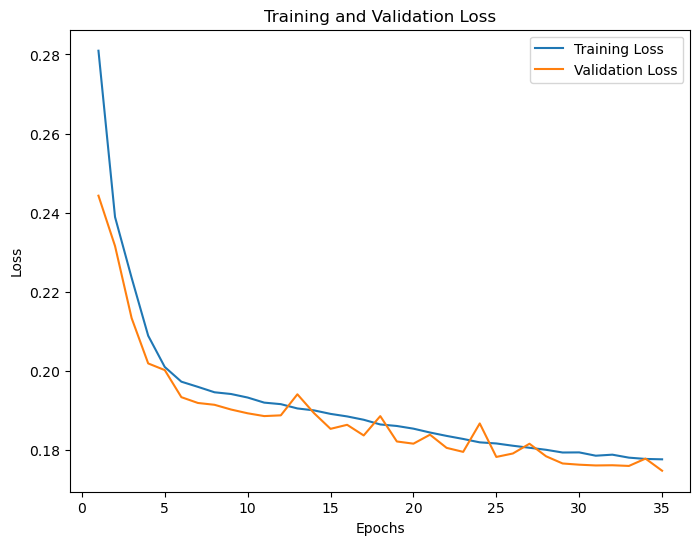

In [13]:
# Calculate AUROC for test predictions
model.eval()
test_scores = []
test_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_scores.extend(outputs.cpu().squeeze().tolist())
        test_labels.extend(labels.cpu().tolist())

# Plot training/validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(valid_losses)+1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Test AUROC: 0.8195


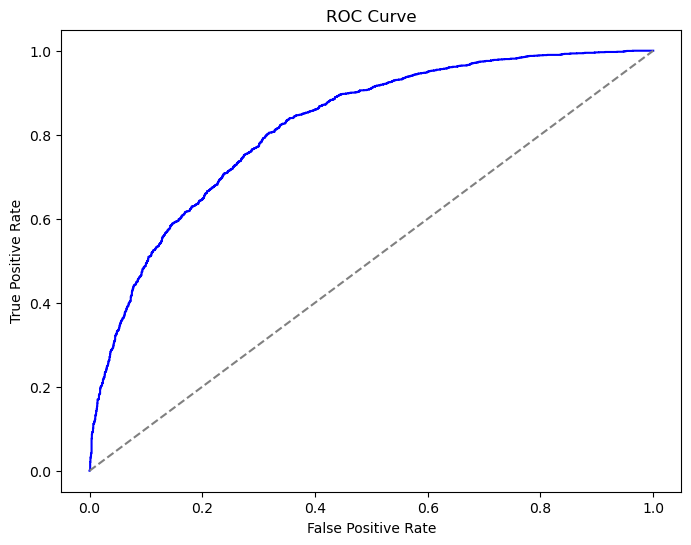

In [14]:
test_auroc = roc_auc_score(test_labels, test_scores)
print(f"Test AUROC: {test_auroc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()